In [286]:
from pandas.io.sas.sas_constants import os_name_offset

"""
Clase: rnn

Objetivo: modelo

Cambios:

    1. Creacion de modelo aquesada 07-07-2025
"""

'\nClase: rnn\n\nObjetivo: modelo\n\nCambios:\n\n    1. Creacion de modelo aquesada 07-07-2025\n'

In [215]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from src.utils.metrics import obtener_ruta_app
import os



In [216]:
ruta = os.path.join(obtener_ruta_app(),"data/processed/ANN/recomendaciones.csv")

df = pd.read_csv(ruta,encoding = "ISO-8859-1",delimiter=',')

In [217]:
df

,YEAR,MONTH,lluvia_mm,temp_max,temp_min,humedad,ph_suelo,Recomendacion
0,1981,JAN,2.64,23.90,14.19,88.79,3.90,fertilizacion
1,1982,JAN,3.30,24.54,14.02,89.43,6.71,poda_preventiva
2,1983,JAN,1.38,26.13,15.75,88.61,5.63,fertilizacion
3,1984,JAN,0.69,23.68,13.14,87.41,8.37,riego
4,1985,JAN,1.94,23.45,14.37,86.96,4.78,fertilizacion
...,...,...,...,...,...,...,...,...
523,2020,DEC,10.77,24.26,13.57,91.87,6.67,poda_preventiva
524,2021,DEC,4.18,24.62,16.47,91.61,8.50,poda_preventiva
525,2022,DEC,3.39,24.12,15.47,90.88,6.84,poda_preventiva
526,2023,DEC,4.84,25.70,16.68,91.62,5.19,fertilizacion


In [218]:
df.drop(columns=["YEAR", "MONTH"], inplace=True)

In [219]:
#Transformar variables categoricas
dummies = pd.get_dummies(df[['Recomendacion']]) #se puede añadir drop_first=True evita redundancia y evita crear una columna por cada variable
df_post = pd.concat([df,dummies],axis=1)
df_post = df_post.drop(['Recomendacion'],axis=1)

In [220]:
df_post

,lluvia_mm,temp_max,temp_min,humedad,ph_suelo,Recomendacion_fertilizacion,Recomendacion_poda_preventiva,Recomendacion_riego
0,2.64,23.90,14.19,88.79,3.90,True,False,False
1,3.30,24.54,14.02,89.43,6.71,False,True,False
2,1.38,26.13,15.75,88.61,5.63,True,False,False
3,0.69,23.68,13.14,87.41,8.37,False,False,True
4,1.94,23.45,14.37,86.96,4.78,True,False,False
...,...,...,...,...,...,...,...,...
523,10.77,24.26,13.57,91.87,6.67,False,True,False
524,4.18,24.62,16.47,91.61,8.50,False,True,False
525,3.39,24.12,15.47,90.88,6.84,False,True,False
526,4.84,25.70,16.68,91.62,5.19,True,False,False


In [221]:
from sklearn.preprocessing import StandardScaler

# Normalizar columnas numericas
columnas_numericas = ['lluvia_mm', 'temp_max', 'temp_min', 'humedad','ph_suelo']

# Escalado
scaler = StandardScaler()
df_post[columnas_numericas] = scaler.fit_transform(df_post[columnas_numericas])

In [222]:
df_post

,lluvia_mm,temp_max,temp_min,humedad,ph_suelo,Recomendacion_fertilizacion,Recomendacion_poda_preventiva,Recomendacion_riego
0,-0.692443,-1.449126,-0.972614,0.119914,-1.215223,True,False,False
1,-0.517110,-1.060796,-1.124801,0.266401,0.397437,False,True,False
2,-1.027171,-0.096037,0.423922,0.078714,-0.222376,True,False,False
3,-1.210474,-1.582615,-1.912590,-0.195949,1.350111,False,False,True
4,-0.878403,-1.722171,-0.811475,-0.298948,-0.710191,True,False,False
...,...,...,...,...,...,...,...,...
523,1.467346,-1.230690,-1.527648,0.824882,0.374481,False,True,False
524,-0.283332,-1.012254,1.068477,0.765372,1.424718,False,True,False
525,-0.493201,-1.315638,0.173261,0.598285,0.472044,False,True,False
526,-0.107998,-0.356946,1.256472,0.767661,-0.474892,True,False,False


In [223]:
X = df_post.drop(['Recomendacion_fertilizacion','Recomendacion_poda_preventiva','Recomendacion_riego'],axis=1).values

In [224]:
y = df_post[['Recomendacion_fertilizacion','Recomendacion_poda_preventiva','Recomendacion_riego']]

In [225]:
y

,Recomendacion_fertilizacion,Recomendacion_poda_preventiva,Recomendacion_riego
0,True,False,False
1,False,True,False
2,True,False,False
3,False,False,True
4,True,False,False
...,...,...,...
523,False,True,False
524,False,True,False
525,False,True,False
526,True,False,False


In [226]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=101,stratify=y)

In [227]:
X_train.shape

(396, 5)

In [228]:
X_test.shape

(132, 5)

In [229]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


In [230]:
X_train.shape

(396, 5)

In [231]:
X_test.shape

(132, 5)

In [232]:
X_train

array([[0.36, 0.64, 0.64, 0.79, 0.37],
       [0.04, 0.24, 0.48, 0.55, 0.04],
       [0.12, 0.45, 0.48, 0.65, 0.38],
       ...,
       [0.26, 0.32, 0.64, 0.8 , 0.1 ],
       [0.23, 0.23, 0.53, 0.84, 1.  ],
       [0.03, 0.58, 0.55, 0.44, 0.1 ]])

In [398]:
X_test

array([[ 0.46,  0.36,  0.4 ,  0.91,  0.66],
       [ 0.23,  0.3 ,  0.38,  0.73,  0.24],
       [ 0.07,  0.03,  0.58,  0.72,  0.34],
       [ 0.23,  0.45,  0.64,  0.7 ,  0.25],
       [ 0.03,  0.32,  0.52,  0.61,  0.94],
       [ 0.1 ,  0.48,  0.55,  0.63,  0.71],
       [ 0.24,  0.34,  0.65,  0.81,  0.55],
       [ 0.38,  0.33,  0.51,  0.81,  0.43],
       [ 0.26,  0.25,  0.4 ,  0.86,  0.21],
       [ 0.28,  0.22,  0.68,  0.84,  0.62],
       [ 0.3 ,  0.54,  0.86,  0.67,  0.36],
       [ 0.29,  0.63,  0.82,  0.53,  1.  ],
       [ 0.14,  0.37,  0.48,  0.8 ,  0.83],
       [ 0.29,  0.49,  0.86,  0.81,  0.62],
       [ 0.2 ,  0.33,  0.31,  0.67,  0.86],
       [ 0.09,  0.4 ,  0.4 ,  0.32,  0.59],
       [ 0.27,  0.16,  0.3 ,  0.83,  0.77],
       [ 0.04,  0.84,  0.68,  0.31,  0.16],
       [ 0.63,  0.35,  0.75,  0.9 ,  0.27],
       [ 0.48,  0.41,  0.89,  0.9 ,  0.49],
       [ 0.18,  0.49,  0.67,  0.6 ,  0.94],
       [ 0.17,  0.89,  0.65,  0.38,  0.53],
       [ 0.23,  0.32,  0.81,  0.

In [399]:
X_train

array([[0.36, 0.64, 0.64, 0.79, 0.37],
       [0.04, 0.24, 0.48, 0.55, 0.04],
       [0.12, 0.45, 0.48, 0.65, 0.38],
       ...,
       [0.26, 0.32, 0.64, 0.8 , 0.1 ],
       [0.23, 0.23, 0.53, 0.84, 1.  ],
       [0.03, 0.58, 0.55, 0.44, 0.1 ]])

In [233]:
X_train.max()

np.float64(1.0)

In [295]:
model = Sequential()
# Elegir número de capas (layers)
#https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw
num_neuronas = X_train.shape[1]
# Indicar tantas neuronas de salida como clases a predecir
num_neuronas_salida = y_train.shape[1]
#Capa inicial usando Input
model.add(Dense(units=num_neuronas, activation='relu'))
model.add(Dense(units=num_neuronas, activation='relu'))
model.add(Dense(units=num_neuronas, activation='relu'))
model.add(Dense(num_neuronas_salida, activation='softmax'))  # softmax para multiclase - softmax activation distribuye la probabilidad sobre cada nodo de salida (clase)

# Para clasificación multiclase "categorical_crossentropy"
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['categorical_accuracy'])

In [296]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

In [400]:
# Entrenar el modelo
model.fit(x=X_train,
          y=y_train,
          epochs=1000,
          batch_size=256,
          validation_data=(X_test, y_test), verbose=1,
          callbacks=[early_stop],
           class_weight=pesos_dict
          )

Epoch 1/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - categorical_accuracy: 0.9184 - loss: 0.2679 - val_categorical_accuracy: 0.8864 - val_loss: 0.3383
Epoch 2/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - categorical_accuracy: 0.9145 - loss: 0.2667 - val_categorical_accuracy: 0.9015 - val_loss: 0.3386
Epoch 3/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - categorical_accuracy: 0.9149 - loss: 0.2782 - val_categorical_accuracy: 0.8939 - val_loss: 0.3390
Epoch 4/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - categorical_accuracy: 0.9240 - loss: 0.2563 - val_categorical_accuracy: 0.8939 - val_loss: 0.3389
Epoch 5/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - categorical_accuracy: 0.9136 - loss: 0.2696 - val_categorical_accuracy: 0.8939 - val_loss: 0.3389
Epoch 6/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - categorical_accuracy: 0.9201 - loss: 0.2661 - val_categorical_accuracy: 0.8939 - val_loss: 0.3385
Epoch 7/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - categorical_accuracy: 0.9162 - los

<Axes: >

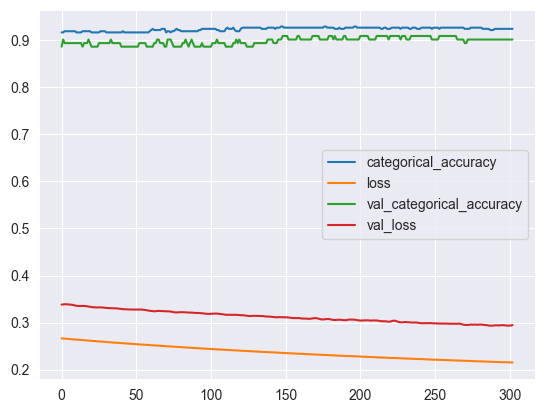

In [401]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

In [339]:
#Evaluacion del Modelo


In [402]:
#Predicción

predictions = model.predict(X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


In [403]:
y_test

,Recomendacion_fertilizacion,Recomendacion_poda_preventiva,Recomendacion_riego
257,False,True,False
223,True,False,False
28,True,False,False
394,True,False,False
38,False,True,False
...,...,...,...
124,False,False,True
12,False,False,True
112,True,False,False
345,False,True,False


In [404]:
predictions

array([[1.49e-04, 9.91e-01, 8.36e-03],
       [8.98e-01, 4.74e-02, 5.47e-02],
       [8.98e-01, 4.74e-02, 5.47e-02],
       [8.33e-01, 3.67e-02, 1.30e-01],
       [7.04e-06, 4.68e-01, 5.32e-01],
       [2.35e-04, 7.84e-02, 9.21e-01],
       [8.32e-02, 8.12e-01, 1.05e-01],
       [7.74e-01, 1.33e-01, 9.35e-02],
       [8.98e-01, 4.74e-02, 5.47e-02],
       [3.37e-03, 9.66e-01, 3.04e-02],
       [5.72e-01, 1.88e-02, 4.09e-01],
       [4.79e-08, 1.50e-02, 9.85e-01],
       [3.50e-05, 8.31e-01, 1.69e-01],
       [7.09e-03, 4.69e-01, 5.24e-01],
       [2.92e-05, 6.93e-01, 3.07e-01],
       [5.95e-03, 7.57e-03, 9.86e-01],
       [6.43e-04, 9.67e-01, 3.28e-02],
       [4.54e-03, 4.94e-05, 9.95e-01],
       [8.98e-01, 4.74e-02, 5.47e-02],
       [3.09e-01, 5.46e-01, 1.45e-01],
       [1.16e-06, 1.64e-01, 8.36e-01],
       [2.24e-04, 2.30e-06, 1.00e+00],
       [1.97e-03, 9.70e-01, 2.75e-02],
       [1.66e-02, 2.32e-04, 9.83e-01],
       [8.64e-01, 4.07e-02, 9.49e-02],
       [8.63e-05, 9.93e-0

In [405]:
predictions_lab = np.argmax(model.predict(X_test), axis=-1)#Utilizando la nueva versión de scikit-learn

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


In [406]:
## Predice las clases para X_test y obtiene el índice de la clase con mayor probabilidad
predictions_lab

array([1, 0, 0, 0, 2, 2, 1, 0, 0, 1, 0, 2, 1, 2, 1, 2, 1, 2, 0, 1, 2, 2,
       1, 2, 0, 1, 0, 1, 1, 1, 0, 1, 0, 2, 0, 0, 1, 2, 0, 2, 0, 0, 0, 2,
       2, 0, 0, 0, 1, 0, 0, 0, 2, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 2, 0, 1,
       0, 2, 1, 1, 1, 0, 1, 0, 1, 2, 0, 0, 2, 1, 2, 2, 0, 1, 1, 0, 1, 1,
       2, 1, 2, 0, 0, 0, 0, 1, 2, 0, 1, 0, 1, 2, 2, 1, 1, 0, 2, 0, 0, 0,
       1, 0, 0, 2, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 2, 1, 2, 2, 2, 0, 1, 0])

In [407]:
# Ajustar las predicciones
predictions_lab_real = predictions_lab+1

In [408]:
predictions_lab_real

array([2, 1, 1, 1, 3, 3, 2, 1, 1, 2, 1, 3, 2, 3, 2, 3, 2, 3, 1, 2, 3, 3,
       2, 3, 1, 2, 1, 2, 2, 2, 1, 2, 1, 3, 1, 1, 2, 3, 1, 3, 1, 1, 1, 3,
       3, 1, 1, 1, 2, 1, 1, 1, 3, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 3, 1, 2,
       1, 3, 2, 2, 2, 1, 2, 1, 2, 3, 1, 1, 3, 2, 3, 3, 1, 2, 2, 1, 2, 2,
       3, 2, 3, 1, 1, 1, 1, 2, 3, 1, 2, 1, 2, 3, 3, 2, 2, 1, 3, 1, 1, 1,
       2, 1, 1, 3, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 3, 2, 3, 3, 3, 1, 2, 1])

In [409]:
df_test_lab = pd.DataFrame(y_test, columns = ['Recomendacion_fertilizacion','Recomendacion_poda_preventiva','Recomendacion_riego'])

In [410]:
df_test_lab

,Recomendacion_fertilizacion,Recomendacion_poda_preventiva,Recomendacion_riego
257,False,True,False
223,True,False,False
28,True,False,False
394,True,False,False
38,False,True,False
...,...,...,...
124,False,False,True
12,False,False,True
112,True,False,False
345,False,True,False


In [411]:
df_test_lab["Clase Real"]=np.where(df_test_lab["Recomendacion_fertilizacion"]==1,1,np.where(df_test_lab["Recomendacion_poda_preventiva"]==1,2,3))

In [412]:
df_test_lab["Clase Real"]

257    2
223    1
28     1
394    1
38     2
      ..
124    3
12     3
112    1
345    2
43     2
Name: Clase Real, Length: 132, dtype: int64

In [414]:
clases=[1, 2, 3]

In [415]:
#Convertir Clase Real en un array
array_clase_real = df_test_lab["Clase Real"].to_numpy()

In [416]:
#Generar la Matriz de confusion
confusion_matrix(array_clase_real, predictions_lab_real, labels=clases)

array([[48,  2,  1],
       [ 1, 41,  1],
       [ 3,  5, 30]])

In [417]:
#Funcion para mostrar Matrix de confusion
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: https://datascience.stackexchange.com/questions/40067/confusion-matrix-three-classes-python/40068
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix sin normalizar')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix sin normalizar
[[48  2  1]
 [ 1 41  1]
 [ 3  5 30]]


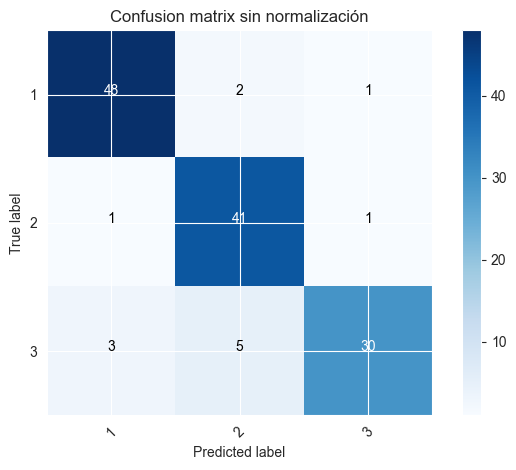

In [418]:
#Mostrar grafico de Matrix de confusion
cnf_matrix = confusion_matrix(array_clase_real, predictions_lab_real, labels=clases)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=clases,
                      title='Confusion matrix sin normalización')

In [419]:
#Verificar el % de aciertos
print(classification_report(array_clase_real, predictions_lab_real))

              precision    recall  f1-score   support

           1       0.92      0.94      0.93        51
           2       0.85      0.95      0.90        43
           3       0.94      0.79      0.86        38

    accuracy                           0.90       132
   macro avg       0.90      0.89      0.90       132
weighted avg       0.90      0.90      0.90       132



In [431]:
#Cargar Dataset Preprocesado
df_pred = pd.read_csv('../data/processed/ANN/recomendaciones.csv')
df_pred.head()

,YEAR,MONTH,lluvia_mm,temp_max,temp_min,humedad,ph_suelo,Recomendacion
0,1981,JAN,2.64,23.90,14.19,88.79,3.90,fertilizacion
1,1982,JAN,3.30,24.54,14.02,89.43,6.71,poda_preventiva
2,1983,JAN,1.38,26.13,15.75,88.61,5.63,fertilizacion
3,1984,JAN,0.69,23.68,13.14,87.41,8.37,riego
4,1985,JAN,1.94,23.45,14.37,86.96,4.78,fertilizacion


In [432]:
#Eliminar columnas y scalar con resultados anteriores
X_pred = df_pred.drop(['Recomendacion','YEAR','MONTH'], axis=1).values
X_pred

array([[ 2.64, 23.9 , 14.19, 88.79,  3.9 ],
       [ 3.3 , 24.54, 14.02, 89.43,  6.71],
       [ 1.38, 26.13, 15.75, 88.61,  5.63],
       ...,
       [ 3.39, 24.12, 15.47, 90.88,  6.84],
       [ 4.84, 25.7 , 16.68, 91.62,  5.19],
       [ 7.89, 24.69, 16.22, 93.15,  5.64]])

In [433]:
X_pred= scaler.fit_transform(X_pred)
#Realizamos predicción
resultado = np.argmax(model.predict(X_pred), axis=-1) + 1


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [434]:
resultado

array([1, 2, 1, 2, 1, 1, 1, 2, 2, 2, 1, 2, 3, 1, 3, 2, 1, 3, 1, 2, 1, 1,
       2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1,
       2, 1, 3, 1, 1, 1, 1, 3, 3, 3, 1, 3, 3, 3, 3, 1, 1, 3, 2, 2, 2, 2,
       2, 3, 1, 1, 3, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3,
       3, 2, 1, 1, 3, 1, 3, 3, 3, 1, 3, 3, 2, 3, 3, 1, 3, 3, 3, 3, 1, 3,
       2, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3,
       3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 2, 2, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 2, 1, 3, 1,
       1, 1, 3, 1, 1, 1, 3, 2, 3, 3, 3, 3, 2, 3, 2, 1, 2, 1, 2, 2, 3, 2,
       2, 1, 3, 1, 1, 1, 1, 3, 1, 3, 1, 3, 1, 3, 2, 3, 2, 2, 2, 2, 1, 2,
       1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1,
       2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2,
       2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1,

In [435]:
#Unimos en un dataframe los datos a predecir con su predicción
df_pred['PREDICCIÓN']=pd.DataFrame(resultado)
df_pred

,YEAR,MONTH,lluvia_mm,temp_max,temp_min,humedad,ph_suelo,Recomendacion,PREDICCIÓN
0,1981,JAN,2.64,23.90,14.19,88.79,3.90,fertilizacion,1
1,1982,JAN,3.30,24.54,14.02,89.43,6.71,poda_preventiva,2
2,1983,JAN,1.38,26.13,15.75,88.61,5.63,fertilizacion,1
3,1984,JAN,0.69,23.68,13.14,87.41,8.37,riego,2
4,1985,JAN,1.94,23.45,14.37,86.96,4.78,fertilizacion,1
...,...,...,...,...,...,...,...,...,...
523,2020,DEC,10.77,24.26,13.57,91.87,6.67,poda_preventiva,2
524,2021,DEC,4.18,24.62,16.47,91.61,8.50,poda_preventiva,2
525,2022,DEC,3.39,24.12,15.47,90.88,6.84,poda_preventiva,2
526,2023,DEC,4.84,25.70,16.68,91.62,5.19,fertilizacion,1


In [437]:
import joblib
#Guardar el modelo
from tensorflow.keras.models import load_model
model.save('modelo_pred_cultivopapa.h5')
joblib.dump(scaler, '../models/scaler_ANN.pkl')

['../models/scaler_ANN.pkl']